In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.as.300.bin.gz
!gunzip cc.as.300.bin.gz


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.5365 - loss: 0.6870

51/51 ━━━━━━━━━━━━━━━━━━━━ 37s 611ms/step - accuracy: 0.5371 - loss: 0.6868 - val_accuracy: 0.6720 - val_loss: 0.6302
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.7790 - loss: 0.5299

51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 618ms/step - accuracy: 0.7789 - loss: 0.5294 - val_accuracy: 0.6955 - val_loss: 0.5953
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 602ms/step - accuracy: 0.8938 - loss: 0.2654 - val_accuracy: 0.6980 - val_loss: 0.6525
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 615ms/step - accuracy: 0.9636 - loss: 0.1202 - val_accuracy: 0.6832 - val_loss: 0.8239
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step
Accuracy:  0.6955
Precision: 0.6085
Recall:    0.7633
F1 Score:  0.6772


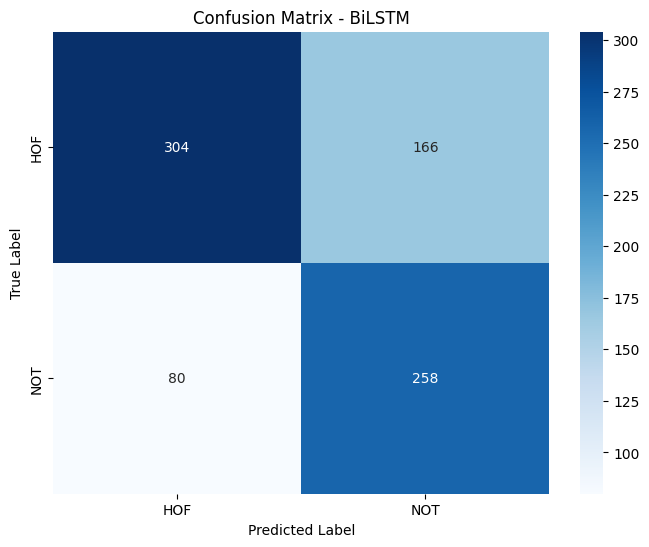

In [3]:
# Install required libraries
!pip install fasttext

# Imports
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import fasttext

# Load dataset
df = pd.read_csv('sd.csv')  # Ensure this file exists in the working directory

X = df['text']
y = df['task_1']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Stratified train-test split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in sss.split(X, y_encoded):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

# Tokenization
max_vocab_size = 20000
max_sequence_length = 100
embedding_dim = 300

tokenizer = Tokenizer(num_words=max_vocab_size, lower=True)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length)

# Load FastText Assamese model
ft = fasttext.load_model('cc.as.300.bin')

# Embedding matrix
embedding_matrix = np.zeros((max_vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < max_vocab_size:
        embedding_matrix[i] = ft.get_word_vector(word)

# Compute class weights
cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(cw))

# Build BiLSTM model
model = Sequential()
model.add(Embedding(input_dim=max_vocab_size,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_sequence_length,
                    trainable=True))
model.add(Bidirectional(LSTM(units=128, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

# Train model
model.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test_pad, y_test),
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

# Predict
y_pred_prob = model.predict(X_test_pad)
y_pred_binary = (y_pred_prob > 0.5).astype(int).flatten()

# Metrics
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - BiLSTM")
plt.show()
